In [1]:
import gym
import gym_anytrading

env = gym.make('forex-v0', frame_bound=(50, 2000), window_size=10)

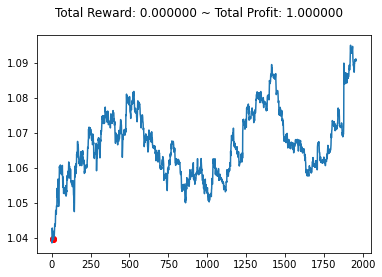

In [2]:
env.reset()
env.render()

[[ 1.08977e+00 -1.00000e-05]
 [ 1.09073e+00  9.60000e-04]
 [ 1.09039e+00 -3.40000e-04]
 [ 1.09054e+00  1.50000e-04]
 [ 1.09090e+00  3.60000e-04]
 [ 1.09087e+00 -3.00000e-05]
 [ 1.09070e+00 -1.70000e-04]
 [ 1.09097e+00  2.70000e-04]
 [ 1.09105e+00  8.00000e-05]
 [ 1.09091e+00 -1.40000e-04]]
info: {'total_reward': 273.3999999999901, 'total_profit': 0.8602945398121838, 'position': 1}


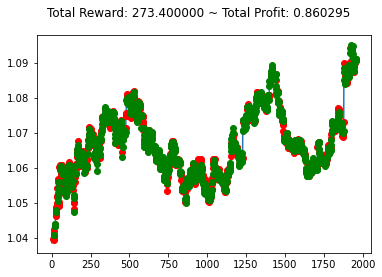

In [3]:
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print(observation)
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

In [385]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainEpisodeLogger

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [381]:
import json
import numpy as np

class FileEpisodeLogger(TrainEpisodeLogger):
    def __init__(self, filepath):
        TrainEpisodeLogger.__init__(self)
        self.filepath = filepath
        
    def on_episode_end(self, episode, logs):
        episode_steps = len(self.observations[episode])
        variables = [episode+1, episode_steps, np.sum(self.rewards[episode]), np.mean(self.rewards[episode]), np.mean(self.actions[episode])]
        row = ''
        for var in variables:
            row += '{},'.format(var)
        # Overwrite already open file. We can simply seek to the beginning since the file will
        # grow strictly monotonously.
        with open(self.filepath,'a') as fd:
            fd.write(row[:-1] + '\n')

In [417]:
class EnvProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 2  # (height, width, channel)
        return self.process_obs_1(observation)
    
    def process_obs_1(self, observation):
        prices = []
        diff = []
        for o in observation:
            prices.append(o[0])
            diff.append(o[1])
        prices = preprocessing.normalize([prices], norm='l2', axis=1, copy=True, return_norm=False)[0]
        diff = preprocessing.normalize([diff], norm='l2', axis=1, copy=True, return_norm=False)[0]
        new_obs = np.column_stack((prices, diff))
        return new_obs
    
    def process_obs_2(self, observation):
        prices = []
        diff = []
        for o in observation:
            prices.append(o[0])
            diff.append(o[1] / o[0] * 100)
        prices = preprocessing.normalize([prices], norm='l2', axis=1, copy=True, return_norm=False)[0]
        new_obs = np.column_stack((prices, diff))
        return new_obs
        
    def process_state_batch(self, batch):
#         print(batch)
        return batch

    def process_reward(self, reward):
        return reward

class DDPGEnvProcessor(EnvProcessor):
    def process_action(self,action):
        return np.argmax(action)
    
class CustomEpsGreedyQPolicy(EpsGreedyQPolicy):
    def __init__(self, eps=0.1, update_interval=100):
        EpsGreedyQPolicy.__init__(self, eps)
        self.update_interval = update_interval
        self.count = 0
        self.init_eps = self.eps
        
    def select_action(self, q_values):
        assert q_values.ndim == 1
        nb_actions = q_values.shape[0]

        if np.random.uniform() < self.eps:
            action = np.random.randint(0, nb_actions)
        else:
            action = np.argmax(q_values)
        self.count += 1
        if (self.count % self.update_interval) == 0:
            self.eps = self.init_eps / (self.count / self.update_interval)
            print(self.eps)
        return action

In [542]:
nb_actions = env.action_space.n

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_80 (Flatten)         (None, 20)                0         
_________________________________________________________________
dropout_107 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_235 (Dense)            (None, 32)                672       
_________________________________________________________________
activation_235 (Activation)  (None, 32)                0         
_________________________________________________________________
dropout_108 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_236 (Dense)            (None, 16)                528       
_________________________________________________________________
activation_236 (Activation)  (None, 16)                0         
__________

In [569]:
# 3 = enable_double_dqn=True, nb_steps=1000000, EpsGreedyQPolicy **
# 4 = enable_double_dqn=True, nb_steps=100000, EpsGreedyQPolicy
# 5 = enable_double_dqn=True, nb_steps=100000, BoltzmannQPolicy **
# 6 = enable_double_dqn=True, nb_steps=1000000, CustomEpsGreedyQPolicy, process_obs_2
# 7 = enable_double_dqn=True, nb_steps=1000000, EpsGreedyQPolicy, process_obs_2 **
# 8 = enable_double_dqn=True, nb_steps=1000000, CustomEpsGreedyQPolicy **
# 9 = enable_double_dqn=True, nb_steps=1000000, CustomEpsGreedyQPolicy(update_interval=2500), train_interval=256, batch_size=512
# 10 = enable_double_dqn=True, nb_steps=1000000, BoltzmannQPolicy, train_interval=256, batch_size=512 **
# 11 = DDPG, train_interval=256, batch_size=512 ***
# 12 = enable_double_dqn=True, nb_steps=1000000, BoltzmannQPolicy, train_interval=32, batch_size=64 
# 13 = DDPG, train_interval=128, batch_size=64 ***
# 14 = DDPG, train_interval=128, batch_size=256, lr = 0.01, target_model_update=0.01, gamma=0.9
# 15 = DDPG, train_interval=128, batch_size=256, lr = 0.0001, target_model_update=0.0001, gamma=0.9
train_no = 14
weights_filename = 'dqn_weights_{}.h5f'.format(train_no)
checkpoint_weights_filename = 'dqn_weights_{step}_'+'{}.h5f'.format(train_no)
log_filename = 'dqn_log_{}.csv'.format(train_no)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileEpisodeLogger(log_filename)]

In [543]:
processor = EnvProcessor()
memory = SequentialMemory(limit=100000, window_length=1)
# policy = CustomEpsGreedyQPolicy(update_interval = 2500, eps = 1.0)
policy = BoltzmannQPolicy()
agent = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=20,
               target_model_update=1e-2, policy=policy, batch_size=64, processor=processor, 
               train_interval=32, enable_double_dqn=True)
agent.compile(Adam(lr=1e-3), metrics=['mae'])


## WIth DDPG

In [575]:
# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dropout(0.2))
actor.add(Dense(32))
actor.add(Activation('relu'))
actor.add(Dropout(0.2))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('softmax'))
# print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dropout(0.2)(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Dense(16)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('softmax')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
# print(critic.summary())


In [576]:
processor = DDPGEnvProcessor()
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process,processor=processor, gamma=.9, target_model_update=1e-2, 
                  batch_size=256, train_interval=128)
agent.compile(Adam(lr=1e-2), metrics=['mae'])


In [ ]:
agent.fit(env, nb_steps=1000000, callbacks=callbacks, visualize=False, verbose=2)
agent.save_weights('dqn_weights_{}_final.h5f'.format(train_no), overwrite=True)

Training for 1000000 steps ...
Training for 1000000 steps ...
   1949/1000000: episode: 1, duration: 29.422s, episode steps: 1949, steps per second: 66, episode reward: 158.000, mean reward: 0.081 [-214.900, 226.700], mean action: 0.119 [0.000, 1.000], mean observation: 0.157 [-0.973, 0.985], loss: 88.213459, mean_absolute_error: 2.041250, mean_q: 1.000000
   3898/1000000: episode: 2, duration: 7.090s, episode steps: 1949, steps per second: 275, episode reward: -95.000, mean reward: -0.049 [-270.600, 102.900], mean action: 0.226 [0.000, 1.000], mean observation: 0.157 [-0.973, 0.985], loss: 30.976951, mean_absolute_error: 1.031042, mean_q: 1.000000
   5847/1000000: episode: 3, duration: 6.988s, episode steps: 1949, steps per second: 279, episode reward: -217.400, mean reward: -0.112 [-149.400, 67.900], mean action: 0.578 [0.000, 1.000], mean observation: 0.157 [-0.973, 0.985], loss: 59.096769, mean_absolute_error: 1.415703, mean_q: 1.000000
   7796/1000000: episode: 4, duration: 6.707s

## Test

In [562]:
no = 13
agent.load_weights('dqn_weights_{}_final.h5f'.format(no))

In [563]:
env_test = gym.make('forex-v0', frame_bound=(50,2000), window_size=10)
env_test.trade_fee = 0
env_test.reset()

array([[ 1.04663e+00,  0.00000e+00],
       [ 1.04666e+00,  3.00000e-05],
       [ 1.04738e+00,  7.20000e-04],
       [ 1.04725e+00, -1.30000e-04],
       [ 1.04705e+00, -2.00000e-04],
       [ 1.04668e+00, -3.70000e-04],
       [ 1.04619e+00, -4.90000e-04],
       [ 1.04610e+00, -9.00000e-05],
       [ 1.04610e+00,  0.00000e+00],
       [ 1.04552e+00, -5.80000e-04]])

In [564]:
agent.test(env_test,visualize=False)

Testing for 1 episodes ...
Episode 1: reward: 1295.000, steps: 6200


6.243722516486863


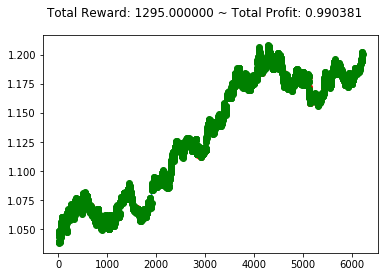

In [565]:
import matplotlib.pyplot as plt
print(env_test.max_possible_profit())
plt.cla()
env_test.render_all()
plt.show()

## plot train graph

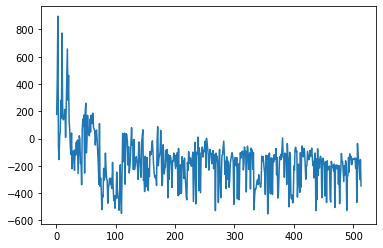

In [567]:
import pandas
no = 9

csv_data = pandas.read_csv('dqn_log_{}.csv'.format(no), delimiter=',', header=None)
plt.plot(csv_data[0],csv_data[2])